<font size = 10> **Creating a mask for MEASO regions** </font>

# Loading relevant libraries

In [15]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import geopandas
import regionmask
import numpy as np
import ZonalStatsFunctions as zsf

# Loading shapefile with MEASO regions
The mask for the MEASO regions was created based on shapefile from the `measoshapes` R package.

In [5]:
#Note that the full file path is being used.
regions = geopandas.read_file(r'/g/data/v45/la6889/GIS_DataBase/Shapefiles/MEASO/measo_wgs84.shp')
regions = regions.query('zone != "Temperate"').query('zone != "Northern"')
regions

,name,sector,zone,fill,LongName,geometry
0,WPA,West Pacific,Antarctic,#016074FF,West Pacific Antarctic,"POLYGON ((-180.00000 -64.70000, -166.00000 -64..."
1,WPA,West Pacific,Antarctic,#BCECFEFF,West Pacific Antarctic,"POLYGON ((-180.00000 -64.70000, -166.00000 -64..."
2,WPS,West Pacific,Subantarctic,#1094AFFF,West Pacific Subantarctic,"POLYGON ((-125.00000 -65.20000, -128.00000 -65..."
5,EPA,East Pacific,Antarctic,#FFFFFFFF,East Pacific Antarctic,"POLYGON ((-125.00000 -85.00000, -125.00000 -65..."
6,EPS,East Pacific,Subantarctic,#5F9EA0FF,East Pacific Subantarctic,"POLYGON ((-125.00000 -65.20000, -125.00000 -56..."
9,AOA,Atlantic,Antarctic,#BCECFEFF,Atlantic Antarctic,"POLYGON ((-59.00000 -59.40791, -59.00000 -58.6..."
11,AOS,Atlantic,Subantarctic,#1094AFFF,Atlantic Subantarctic,"POLYGON ((30.00000 -56.50000, 28.00000 -56.500..."
13,CIA,Central Indian,Antarctic,#FFFFFFFF,Central Indian Antarctic,"POLYGON ((30.00000 -85.00000, 30.00000 -56.500..."
14,CIS,Central Indian,Subantarctic,#5F9EA0FF,Central Indian Subantarctic,"POLYGON ((30.00000 -56.50000, 30.00000 -47.900..."
17,EIA,East Indian,Antarctic,#EAFAFFFF,East Indian Antarctic,"POLYGON ((115.00000 -59.50000, 116.00000 -59.5..."


# Loading ACCESS-ESM1.5 data sample for the Southern Ocean 

In [18]:
data = xr.open_dataarray(r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/SeaIceAdv_1965-2018.nc')
data = zsf.corrlong(data)
data

<xarray.DataArray 'yt_ocean' (yt_ocean: 740)>
array([-81.108632, -81.066392, -81.024153, ..., -45.177229, -45.106694,
       -45.036071])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -45.18 -45.11 -45.04

# Checking MEASO regions and ACCESS-ESM1.5 data are correctly aligned

<AxesSubplot:title={'center':'time = 1965-02-15'}, xlabel='xt_ocean', ylabel='yt_ocean'>

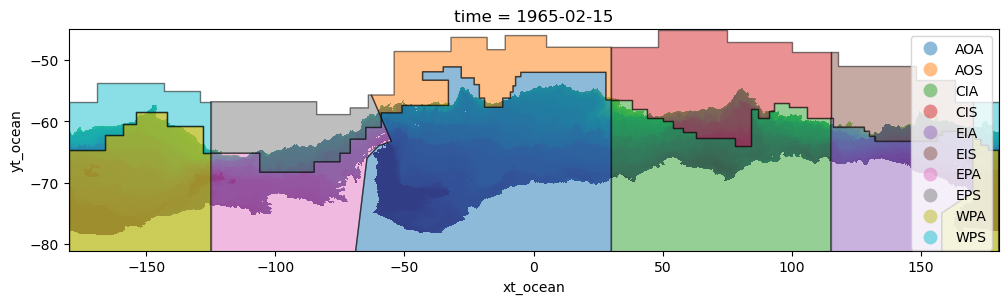

In [17]:
# Plot shapefile over the raster to ensure they both have the same CRS and cover the same area
#Initialise figure
fig, ax = plt.subplots(figsize = (12, 15))

#Plot just one timestep of the data array
# sst_upper200mean_SO[0].plot(ax = ax, add_colorbar = False)
data[0].plot(ax = ax, add_colorbar = False)

#Plot shapefile over the top and show each sector in different colour
regions.plot(ax = ax, column = 'name', legend = True, alpha = 0.5, edgecolor = 'black')

# Creating an xarray mask of the MEASO regions

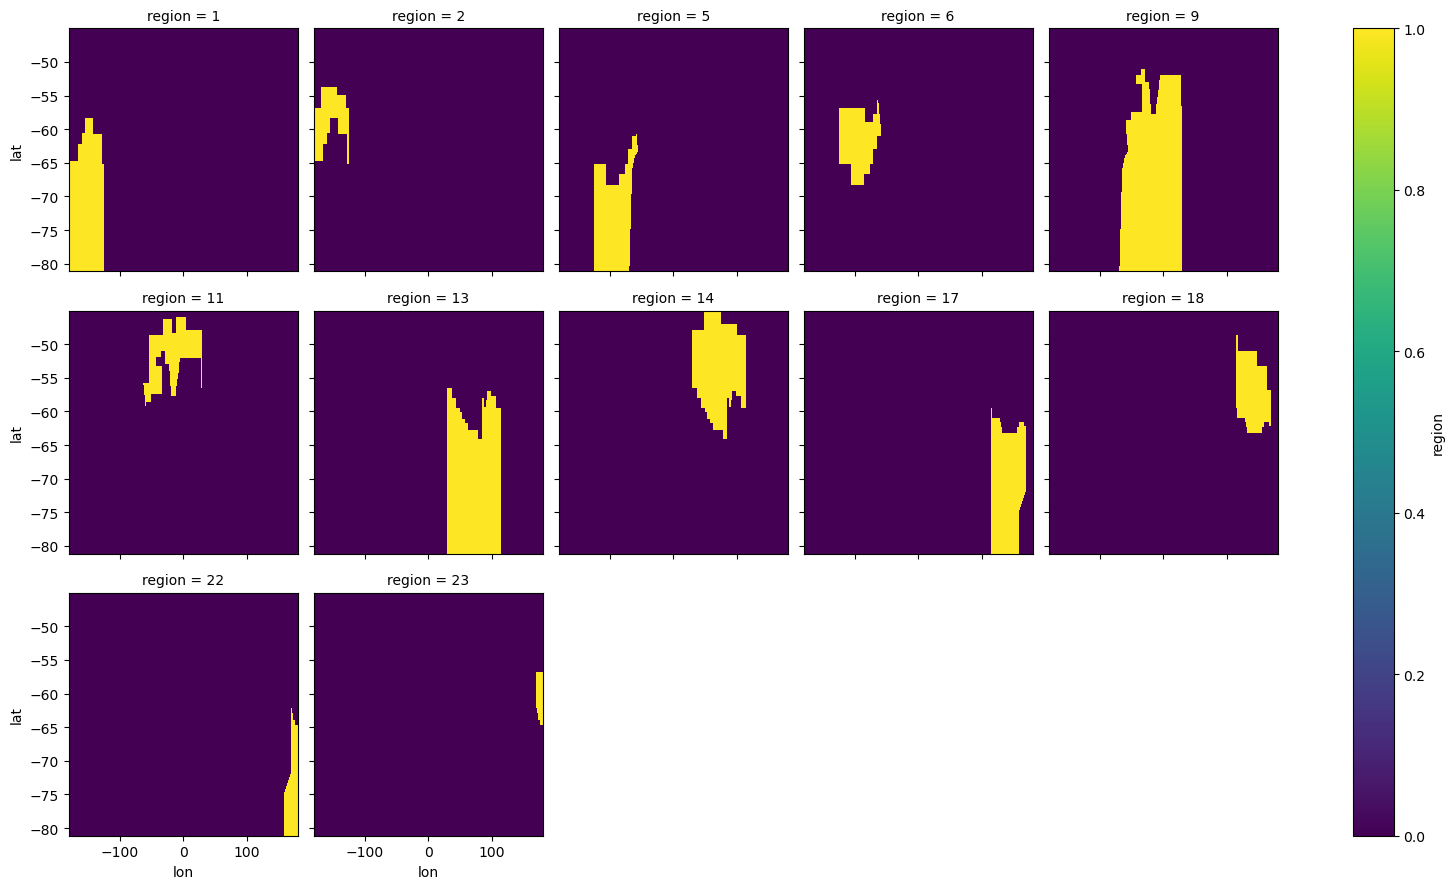

In [19]:
# Extracting latitude and longitude values from SO data array
longitude = data['xt_ocean'].values
latitude = SO['yt_ocean'].values

#Creating a 3D mask, which includes regions as a dimension
mask3D = regionmask.mask_3D_geopandas(regions, longitude, latitude)
#Plotting all regions within mask to check they are correct
mask3D.plot(col = 'region', col_wrap = 5)

## Renaming regions
When the mask was created, numeric values were assigned to the `region` dimension which correspond to their index in the shapefile used to create the mask. In this step, regions will be renamed so the shorten version of its name (column `name` in the shapefile) will appear as the value in the `region` dimension of the mask.

In [38]:
#Getting names of regions from the shapefile to include them in mask (keep the same order as they appear)
reg_names = regions.sector.values.tolist()

#Remove the first and 12th item in the list as it is not included in the mask (see figure above) 
del reg_names[0]
del reg_names[-3]
reg_names

#Replacing numbered regions for names in the mask
mask3D['region'] = reg_names

#Checking results
mask3D.region

<xarray.DataArray 'region' (region: 12)>
array(['West Pacific', 'West Pacific', 'East Pacific', 'East Pacific',
       'Atlantic', 'Atlantic', 'Central Indian', 'Central Indian',
       'East Indian', 'East Indian', 'West Pacific', 'West Pacific'],
      dtype='<U14')
Coordinates:
  * region   (region) <U14 'West Pacific' 'West Pacific' ... 'West Pacific'

## Merging duplicate West Pacific areas
Areas within the West Pacific sector appear twice in the mask. This is because these areas are split in two along the -180/+180 longitude boundary.  
Areas with the same name will be summed together. Since each area is a boolean, the resulting data array will include `True` only for pixels within the boundaries of each area.  
*Remember boolean data represent `True` as `1` and `False` as `0`.*

In [40]:
#Creating a list of unique sectors
unique_regions = np.unique(regions.sector.values).tolist()

['Atlantic', 'Central Indian', 'East Indian', 'East Pacific', 'West Pacific']

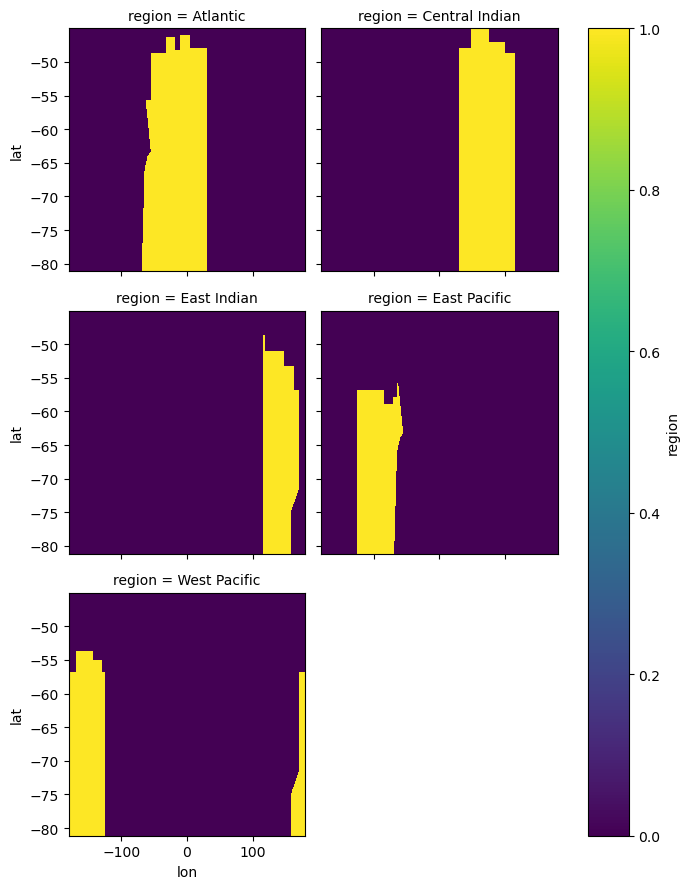

In [42]:
#Creating an empty variable to store the corrected areas
corr_reg = []

#We will loop through each West Pacific area
for i in unique_regions:
    reg = [i]
    #Sum together areas with the same value under region
    x = mask3D.sel(region = i).sum('region')
    #Include the region dimension again as this will be automatically dropped after summing
    x = x.expand_dims({'region': reg})
    #Include resulting data arrays in the empty variable created at the beginning of this section
    corr_reg.append(x)

#Concatenate all information into one new data array
corrected_mask = xr.concat(corr_reg, 'region')

#Checking the final result, which should include 25 areas in total
corrected_mask.plot(col = 'region', col_wrap = 2)

## Replacing zero values with NaN

In [43]:
corrected_mask = corrected_mask.where(corrected_mask != 0)

## Renaming coordinate dimensions
Coordinate dimensions are renamed so they match the names in ACCESS-ESM1.5.

In [44]:
corrected_mask = corrected_mask.rename({'lon': 'xt_ocean','lat': 'yt_ocean'})

## Checking mask has been correctly calculated

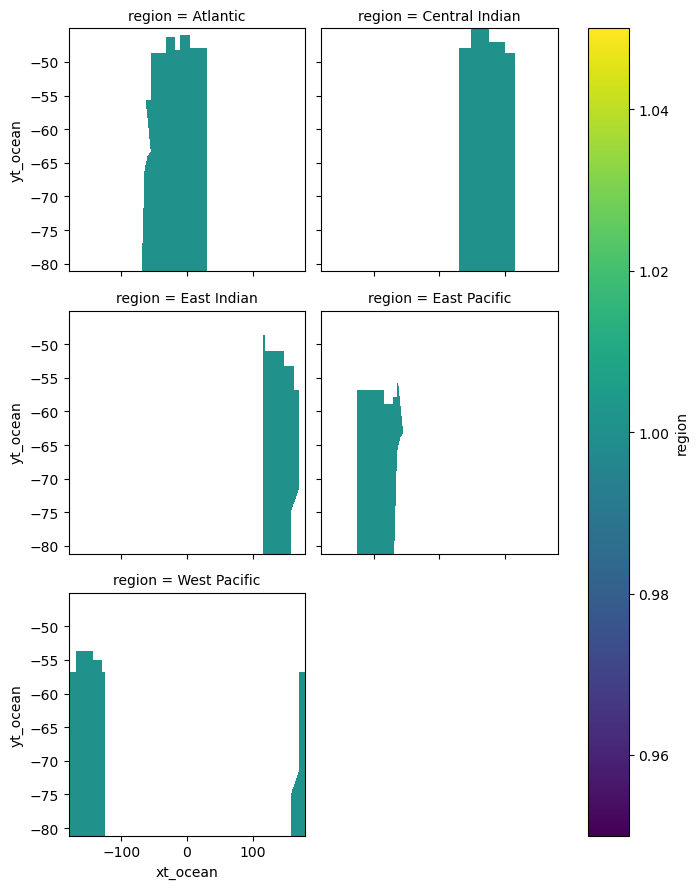

In [45]:
corrected_mask.plot(col = 'region', col_wrap = 2)

## Saving the result mask

In [46]:
corrected_mask.to_netcdf('MEASO_SIS_3Dmask.nc')